# Contrastive explanation method(CEM)

분류가 목적인 머신러닝 모형 $f(x)$ 를 학습시킨 후, '설명 변수 $x$ 를 얼마나 변경시키면 예측범주를 변경할 수 있는가?'에 대한 하나의 해결책이 **counterfactual explainer** 이다. 오직 특정 표본에만 적용되므로 counterfactual explainer는 local explainer이다. 머신러닝 관점에서 **counterfactual** 은 예측된 범주를 원하는 다른 범주로 바꿀 수 있는 최소로 수정한 설명 변수값으로 정의할 수 있다. 이 때, 새로운 설명 변수값은 원래의 설명 변수값에 최대한 가까워야하며 설명 가능해야한다.

Counterfactual을 구하는 explainer 중 본 책에서는 CFI, CEM, CFP, CFRL에 대해 설명하며, 본 챕터에서는 CEM에 대해 설명한다. CFI, CEM은 실수형 tabular 데이터와 image 데이터에 적용할 수 있고, CFP, CFRL은 실수 및 범주형 tabular 데이터, image 데이터에 적용할 수 있다.

---

CEM은 **pertinent positive(PP)** 와 **pertinent negative(PN)** 으로 나뉜다.

PP는 $\hat{y}$로 예측된 표본이 그렇게 예측되게 하는 결정적인 설명 변수값이다. 반대로, PN은 특정 표본이 다른 범주로 예측되게하는 설명 변수값을 의미한다.

아래의 이미지를 예시로 구체적으로 설명한다.<br>
그림의 첫 번째열은 원본 이미지, 두 번쨰열은 PP 그리고 세 번째 열은 PN을 의미한다.

PP는 하늘색으로 표시되어 있으며, 해당 픽셀들을 제외한 나머지 픽셀을 배경색으로 바꿔도 원래 예측을 유지한다.<br>
PN은 분홍색으로 표시되어 있으며, 해당 픽셀이 원본 이미지에 추가되면 상단에 표시된 값으로 예측 범주가 변경된다.

<div style="text-align: center;">
  <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSRGjJUXWFIo2eDG0B7cMW3BqW3rKk1qXAfMQ&s" alt="이미지 설명" />
  <p style="font-size: 12px; color: grey; text-align: center;">
    <em>
        <a href="https://www.tensorflow.org/tutorials/interpretability/integrated_gradients?hl=ko">
            출처: Explanations based on the Missing: Towards Contrastive Explanations with Pertinent Negatives
        </a>
    </em>
  </p>
</div>

CEM PP는 원본 예측을 유지하는 픽셀을 찾는다는 관점에서 Anchor와 매우 유사한 접근방법이라고 할 수 있다. 두 explainer의 차이점은 다음과 같다.

Anchor에서는 multi-armed bandit 알고리즘으로 픽셀 조합을 찾으며 coverage가 일정 수준이라는 조건이 필요하다.<br>
반면 CEM PP는 coverage를 정의하지 않으며, 손실함수를 통해 픽셀 조합을 찾는다. 이 때, 손실함수 최소화를 위해 일반적인 경사하강법 대신 **FISTA**(후술) 를 적용한다.

## CEM PP

<center>

| Notation              |     설명     |
| :------:              | :---------: |
|    $x_0$              | 설명변수     |
| $f(x_0)_k$            | 입력 $x_0$ 및 예측범주 $k$에 대한 모델의 예측 확률 |
| $t_0$                 | 입력 $x_0$에 대한 모델의 예측 범주 |
| $\delta$              | $x_0$의 일부 픽셀(또는 설명 변수)를 off한 상태의 표본 |
| $L_1$, $L_2$          | 차례대로 $l_1$, $l_2$ norm |
| $L(\delta)$           | 손실함수 |

</center>  

CEM PP의 손실함수는 다음과 같이 정의된다.

$$
L(\delta) = cl^{POS}_{\kappa}(x_0, \delta) + \beta L_1(x_0 - \delta) + L_2(x_0 - \delta) + \gamma L_2(\delta - AE(\delta))
$$
여기서 $l^{POS}_{\kappa}(x_0, \delta)$는 attack loss 항이라고 부르며, 다음과 같이 정의된다.

$$
\begin{align*}
l^{POS}_{\kappa}(x_0, \delta) &= \text{max}(\text{max}_{k \neq t_0}f(\delta)_k - f(\delta)_{t_0}, - \kappa) \\
&= \text{min}( f(\delta)_{t_0} - \text{max}_{k\neq t_0}f(\delta)_k, \kappa)
\end{align*}
$$

$\beta L_1(x_0 - \delta) + L_2(x_0 - \delta)$ 항은 L1, L2 정규화로 $|x_0 - \delta|$ 와 $(x_0 - \delta)^2$ 를 각각 최소화하므로 $\delta$를 $x_0$에 최대한 가깝게 하도록 조정한다.

$l^{POS}_{\kappa}(x_0, \delta)$ 를 살펴보자. $\kappa \geq 0$ 는 하이퍼파라미터로 손실 함수를 최소화하기 위해 $\delta$ 를 조정하면 다음 식을 만족하게 된다.
$$
0 \leq f(\delta)_{t_0} - \text{max}_{k\neq t_0}f(\delta)_k < \kappa
$$
이 때, $\kappa$ 를 0보다 약간 크게 설정하면 $f(\delta)_{t_0}$ 는 $\text{max}_{k\neq t_0}f(\delta)_k$ 보다 약간 크게되어 원래의 입력인 $x_0$ 에 대한 모델의 예측 label인 $t_0$ 를 유지하게 한다.

그러므로, $l^{POS}_{\kappa}(x_0, \delta)$ 는 $\delta$ 가 label $t_0$를 유지하기 위해 최소한으로 남아 있어야 할 설명 변수를 탐지하는 항으로 해석된다.

$\gamma L_2(\delta - AE(\delta))$ 에서 $AE(\delta)$ 는 $\delta$를 autoencoder에 입력하여 복원한 이미지로 $\delta$ 가 학습데이터의 분포를 벗어나지 않도록 하는 안전 장치이다.

위 손실함수는 Fast Iterative Thresholding Algorithm(FISTA)로 최적화하며 $\delta^{(0)} = y^{(0)} = 0$ 로 놓고 아래의 계산을 미리 설정한 반복 횟수인 $I$번 반복하며 $\delta$ 와 $y$를 업데이트한다.

$$
\begin{align*}

\delta^{(n + 1)} &= S_{\beta}( y^{(n)} - \alpha \frac{\partial L(y^{(n)})}{\partial y^{(n)}}) \\ 
y^{(n + 1)} &= \delta^{(n + 1)} + \frac{n}{n + 3} (\delta^{(n + 1)} - \delta^{(n)}) \\
\end{align*}
$$

여기서 $S_\beta(z)$ 는 다음과 같이 정의된다.

$$
S_\beta(z) =
\begin{cases}
    x - \beta, & \quad z > \beta \\
    0,         & \quad  |z| < \beta \\
    z + \beta, & \quad z < -\beta
\end{cases}
$$

$$

$$

$I$ 번의 반복에서 구한 $ \delta^{(1)}, \delta^{(2)}, \dots , \delta^{(I)}$ 중 손실함수를 최소로 하는 $\delta^*$가 CEM PP가 된다.

$$
\delta^* = \text{argmin}_{\delta^{(i)}}( L(\delta^{(1)}), L(\delta^{(2)}), \dots, L(\delta^{(I)}) )
$$

CEM은 손실함수의 미분값을 구해야 하므로 내부 구조를 할 수 있는 미분 가능한 모델에 적용되지만, 입출력만 관측되는 블랙박스 모델에도 적용할 수 있다.

CEM의 약점은 데이터의 속성을 파악해야 하고 손실함수에 있는 하이퍼파라미터의 조절이다. 특히, $c$의 조절은 성공적인 CEM PP, PN 추출에 중요한 역할을 한다.

---

## CEM PN

CEM PN의 손실함수는 CEM PP의 손실함수와 유사하며, $l^{POS}_{\kappa}$ 항을 $l^{NEG}_{\kappa}$ 항으로 변경하고, autoencoder항의의 입력을 $x_0 + \delta$로 변경하면 된다.

CEM PN은 원본 이미지의 absent 픽셀을 present 픽셀로 추가하므로 $x_0 + \delta$ 로 정의된다.

$$
\begin{align*}
L(\delta) &= cl^{NEG}_{\kappa}(x_0, \delta) + \beta L_1(\delta) + L_2(\delta) + \gamma L_2(x_0 + \delta - AE(x_0 + \delta)) \\
l^{NEG}_{\kappa}(x_0, \delta) &= \text{min}(\text{max}_{k\neq t_0}f(x_0 + \delta)_k - f(x_0 + \delta)_{t_0}, \kappa)
\end{align*}
$$

$l^{NEG}_{\kappa}(x_0, \delta)$ 에서 $\delta$ 는 원래의 label $t_0$ 에서 다른 범주로 변화시키는 최소한의 설명 변수 변동이라고 할 수 있다.

CEM PN은 CEM PP와 동일하게 FISTA를 적용하여 $x_0 + \delta$를 구하게 된다.

---

## CEM - 블랙박스 모델의 미분

CEM의 손실함수 값을 계산하기 위해 모델의 내부 구조를 정확하게 안다는 가정하에서 미분값을 계산하고 $\delta$를 업데이트하였다. 그러나 블랙박스 모델을 가정한다면 입력 변수와 예측함수의 결과만 존재한다. 이 때, 손실함수의 미분값은 다음과 같이 계산된다. $p$는 예측함수의 출력을 의미한다.

$$
\frac{\partial L(x)}{\partial x} = \frac{\partial L(x)}{\partial p} \frac{\partial p}{\partial x}
$$

블랙박스 모델의 경우 chain rule이 적용된 각 항의 변동의 상한값을 설정하여 수치 미분을 통해 계산한다.

수치 미분의 정의는 다음과 같다. 다음의 정의에서 $h$을 변동의 상한값으로 생각하면 된다.

정의 첫 번째줄은 전방 차분과 후방 차분의 평균이다.

$$
\begin{align*}
f^{'}(x) &= \lim_{h \to 0} \frac{1}{2} (\frac{f(x + h) - f(h)}{h} - \frac{f(x - h) - f(h)}{h}) \\
&= \lim_{h \to 0} \frac{f(x + h) - f(x - h)}{2h} \\
& \approx \frac{f(x + h) - f(x - h)}{2h}
\end{align*}
$$

---

## CEM의 적용

CEM 적용을 위해 ALIBI 라이브러리를 이용하며, ALIBI 라이브러리의 CEM은 TF1(tensorflow-v1) 구조를 따르므로 CEM을 실행하기 전 반드시 `tf.compat.v1.disable_v2_behavior()`을 실행해야한다. IRIS 데이터를 통해 Tabular 데이터에 대한 적용을 실습한 뒤, MNIST 데이터를 통해 이미지 데이터에 대해 CEM을 적용한다.

CEM의 옵션은 다음과 같다.
<a href="https://docs.seldon.io/projects/alibi/en/latest/api/alibi.explainers.cem.html#module-alibi.explainers.cem">
alibi.explainers.cem API Docs
</a>

|     Argument       |               Data Type                 | 기본값     | 설명 |
|:---------------:   |:----------:                             |:------:   |------|
| model              | `Callable[ndarray]`, `ndarray`, `Model` | -         | 모델의 예측함수 혹은 Tensorflow 모델                       |
| mode               | `str` - `["PP", "PN"]`                  | -         | PP, PN 중 원하는 CEM 입력                                 |
| shape              | `Tuple[int]`                            | -         | CEM을 적용하고자 하는 표본의 차원, 첫 번째 차원은 batch size이어야 함 |
| feature_range      | `Tuple[float]`                          | `(train.min(), train.max())` | CEM을 구할 데이터의 변동범위 지정       |
| no_info_val        | `float`, `ndarray`, `None`              | -1        | non-informative value의 약자로 예측범주에 영향을 주지 않는 설명 변수값 지정 |
| kappa              | `float`                                 | 0.0       | 손실함수의 attack loss 항에서의 $\kappa$ 값                |
| c_init             | `float`                                 | 10.0      | 손실함수의 attack loss항의 계수 $c$의 초기값                |
| c_steps            | `int`                                   | 10        | 손실함수의 attack loss항의 계수 $c$를 update 하는 반복 횟수 |
| beta               | `float`                                 | 0.1       | 손실함수의 $L_1$ 정규화의 계수                             |
| max_iterations     | `int`                                   | 1000      | FISTA의 반복 횟수 $I$                                     |
| learning_rate_init | `float`                                 | 0.01      | FISTA의 학습률 $\alpha$의 초기값, 반복되며 지수적으로 감소  |
| clip               | `Tuple[float]]`                         | (-1000, 1000) | FISTA의 미분값 상한, 하한 지정                         |
| ae_model           | `Optional[Model]`                       | `None`    | 손실함수에 적용되는 autoencoder 모델                       |
| gamma              | `float`                                 | 0.0       | 손실함수의 autoencoder 항의 계수                           |
| eps                | `Tuple[float]`, `Tuple[ndarray]`        | (0.001, 0.001) | 튜플의 첫 번째 요소는 $\frac{\partial L(x)}{\partial p}$에 대한 변화량의 상한 값으로 예측 범주의 차원 혹은 실수값 입력, 두 번째 요소는 $\frac{\partial p}{\partial x}$에 대한 변화량의 상한 값으로 설명 변수의 차원 혹은 실수 입력                                                        |


### Tabular 데이터 - IRIS

다음 실습에서는 IRIS 데이터에 대해 Logistic Regression 모델을 학습시킨 후 Pertinent Negative, Pertinent Positive 순으로 적용한 뒤, 블랙박스 모형을 가정하여 CEM을 적용한다.

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf

tf.get_logger().setLevel(40)
tf.compat.v1.disable_v2_behavior()

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from alibi.explainers import CEM

print("TF version: ", tf.__version__)

TF version:  2.14.0


Scikit-learn에서 IRIS 데이터를 불러오고 표준화 한뒤 학습데이터와 시험데이터로 분리한다.

In [3]:
dataset = load_iris()
feature_names = dataset.feature_names
class_names = list(dataset.target_names)

dataset.data = (dataset.data - dataset.data.mean(axis = 0)) / dataset.data.std(axis = 0)

X_train, y_train = dataset.data[: 145, :], dataset.target[: 145]
X_test, y_test = dataset.data[145:, :], dataset.target[145:]
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape)
print(X_test.shape)

(145, 4)
(5, 4)


Logistic Regression 모델을 Tensorflow의 functional API를 이용하여 정의한다.

In [5]:
def lr_model(): # Logistic Regression
    x_in = Input(shape=(4, ))
    x_out = Dense(3, activation='softmax')(x_in)
    lr = Model(inputs=x_in, outputs=x_out, name='LogisticRegression')
    lr.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return lr

정의한 모델을 선언한 뒤 학습시킨다. 이 때, 모델 재사용을 위해 로컬 저장소에 모델을 저장한다.

In [ ]:
lr = lr_model()
lr.fit(X_train, y_train, batch_size=16, epochs=500, verbose=0)
lr.save('iris_lr.h5', save_format='h5')

In [7]:
lr.summary()

Model: "LogisticRegression"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 3)                 15        
                                                                 
Total params: 15 (60.00 Byte)
Trainable params: 15 (60.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


학습한 모델로 시험데이터의 첫 번째 표본을 예측한다. 이 때, 모델 입력 형식에 맞추기 위해 표본의 차원을 1차원 텐서에서 2차원 텐서 (1, 4)로 수정한다.

In [12]:
idx = 0
X_sample = X_test[idx].reshape(1, -1)
pred = lr.predict(X_sample)

첫 번째 표본에 대하여 *virginica* 로 예측했으며, 예측 확률은 0.915로 나타났다.

In [ ]:
print(f"Prediction on instance to be explained: {class_names[np.argmax(pred)]}")
print(f"Prediction probabilities for each class on the instance: {pred}")

Prediction on instance to be explained: virginica
Prediction probabilities for each class on the instance: [[4.6026718e-05 8.5039645e-02 9.1491431e-01]]


위의 표본에 대하여 CEM PN을 구하기 위해 `CEM`에 전달한 인자를 정의한다.

In [13]:
cem_pn_config = {
    'mode': 'PN',
    'shape': (1, ) + X_train.shape[1:],
    'kappa': 0.2,
    'beta': 0.1,
    'c_init': 10.0,
    'c_steps': 10,
    'max_iterations': 1000,
    'feature_range': (X_train.min() - .1, X_train.max() + 1),
    'clip': (-1000.0, 1000.0),
    'learning_rate_init': 1e-2
}

앞서 저장한 Logistic Regression 모델을 불러온 뒤, CEM에 모델과 인자를 전달하여 객체화한다.

`.fit` 단계에서 `no_info_type='median'`으로 설정하여 non-informative value 즉 예측 중립적인 값을 각 설명 변수의 중앙값으로 설정한다.

`.explain(표본)` 메서드를 통해 해당 표본의 PN을 구하게 된다.

In [ ]:
lr = load_model('iris_lr.h5')
cem_pn = CEM(lr, **cem_pn_config)
cem_pn.fit(X_train, no_info_type='median')
explanation_pn = cem_pn.explain(X_sample, verbose=False)

반환된 변수의 키 값을 확인한다.

key에 `'PN'`과 `'PP'`가 있는 것을 확인할 수 있는데, `CEM` 선언시 `mode`로 설정한 키만 값이 존재하며, 반대는 None 값이 할당되어 있다.

In [16]:
print(explanation_pn.meta.keys())
print(explanation_pn.data.keys())

dict_keys(['name', 'type', 'explanations', 'params', 'version'])
dict_keys(['PN', 'PP', 'PN_pred', 'PP_pred', 'grads_graph', 'grads_num', 'X', 'X_pred'])


`X`에는 원본 표본의 값이 할당되어 있고, `X_pred`에는 모델의 예측 범주가 할당되어 있다.

In [17]:
print(f"Original instance: {explanation_pn.X}")
print(f"Predicted class: {class_names[explanation_pn.X_pred]}")

Original instance: [[ 1.03800476 -0.13197948  0.8195957   1.44883158]]
Predicted class: virginica


`PN`은 원래의 범주 *virginica* 에서 *versicolor* 로 변경하는 설명 변수값을 나타낸다.

값을 확인해보면 세 번째 설명 변수의 값을 음수로 변경하면 예측 범주가 바뀌게 되는 것을 알 수 있다.

In [18]:
print(f"Pertinent negative: {explanation_pn.PN}")
print(f"Predicted class: {class_names[explanation_pn.PN_pred]}")

Pertinent negative: [[ 1.0473335  -0.13197948 -0.39410552  1.4488316 ]]
Predicted class: versicolor


다음으로 CEM PP를 구하기 위해 앞서 정의한 인자에서 `mode`만 `'PP'`로 변경하여 동일 표본에 대해 Pertinent Positive를 반환하고 있다.

In [ ]:
cem_pp_config = cem_pn_config.copy()
cem_pp_config['mode'] = 'PP'

lr = load_model('iris_lr.h5')
cem_pp = CEM(lr, **cem_pp_config)
cem_pp.fit(X_train, no_info_type='median')
explanation_pp = cem_pp.explain(X_sample, verbose=False)

`PP` 값을 확인해보면 세 번째 및 네 번째 설명변수의 값은 원래 값에 비해 변화량이 작은 것을 알 수 있다.

이를 통해 세번째, 네 번째 설명 변수가 현재의 범주 *virginica* 를 유지하는데 핵심적인 역할을 하는 것으로 해석할 수 있다.

In [20]:
print(f"Pertinent positive: {explanation_pp.PP}")
print(f"Predicted class: {class_names[explanation_pp.PP_pred]}")

Pertinent positive: [[8.26795521e-10 1.06415454e-09 1.69607462e-01 1.10057210e+00]]
Predicted class: virginica


미분 구조가 불명확한 블랙박스 모델의 경우 `CEM`에 모델만 전달하는 것으로는 미분을 자동으로 수행할 수 없다. 따라서, 앞서 설명한 
$
\frac{\partial L(x)}{\partial x} = \frac{\partial L(x)}{\partial p} \frac{\partial p}{\partial x}
$
형태로 미분을 수행할 수 있도록 예측 함수(모델의 출력층) 명시해야 한다.

이를 위해서 모델대신 예측 함수를 인자로 전달한다.

In [ ]:
lr = load_model('iris_lr.h5')
predict_fn = lambda x: lr.predict(x)

In [ ]:
cem = CEM(predict_fn, **cem_pn_config)
cem.fit(X_train, no_info_type='median')
explanation = cem.explain(X_sample, verbose=False)

In [22]:
print(f"Original instance: {explanation.X}")
print(f"Precited class: {class_names[explanation.X_pred]}")

Original instance: [[ 1.03800476 -0.13197948  0.8195957   1.44883158]]
Precited class: virginica


In [23]:
print(f"Pertinent negative: {explanation.PN}")
print(f"Predicted class: {class_names[explanation.PN_pred]}")

Pertinent negative: [[ 1.0471114  -0.13197948 -0.39453202  1.4488316 ]]
Predicted class: versicolor


---

## Image 데이터 - MNIST

다음 실습에서는 MNIST 데이터에 대해 CNN 및 autoencoder를 학습시킨 후 CEM PN, PP를 구하여 시각화 한다.

In [24]:
import os

import tensorflow as tf
tf.get_logger().setLevel(40)
tf.compat.v1.disable_v2_behavior()

import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from alibi.explainers import CEM

Keras에서 MNIST 데이터를 불러온다.

X_train shape:  (60000, 28, 28)
y_train shape:  (60000,)


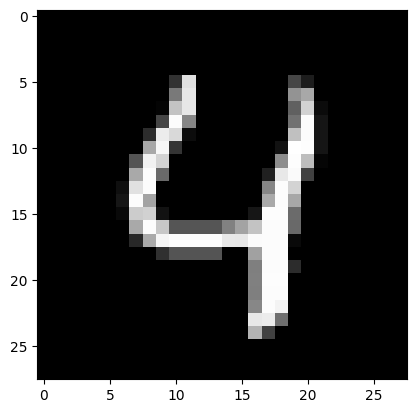

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

plt.gray()
plt.imshow(X_test[4])

0 ~ 255의 값으로 이루어져있는 gray scale 이미지를 255로 나누어 0 ~ 1의 값을 갖도록 표준화한다.

Tensorflow 모델의 입력 차원에 맞추기 위하여 3차원 텐서 image 데이터를 4차원 텐서로 수정한다. 목적 변수 또한 one-hot encoding을 적용한다.

In [30]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') /  255
X_train = np.reshape(X_train, X_train.shape + (1, ))
X_test = np.reshape(X_test, X_test.shape + (1, ))
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (60000, 28, 28, 1)
X_test shape:  (10000, 28, 28, 1)
y_train shape:  (60000, 10)
y_test shape:  (10000, 10)


다음으로 각 픽셀의 값이 -0.5 ~ 0.5가 되도록 표준화한다.

In [31]:
xmin, xmax = -0.5, 0.5
X_train = ((X_train - X_train.min()) / (X_train.max() - X_train.min())) * (xmax - xmin) + xmin
X_test = ((X_test - X_test.min()) / (X_test.max() - X_test.min())) * (xmax - xmin) + xmin

CNN 모델을 Tensorflow functional API를 이용하여 정의한다.

In [26]:
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPool2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPool2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPool2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)
    cnn = Model(inputs=x_in, outputs=x_out, name='CNN')
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return cnn

정의한 모델을 선언한 뒤 학습시킨다. 이 때, 모델 재사용을 위해 로컬 저장소에 모델을 저장한다.

In [33]:
cnn = cnn_model()
cnn.fit(X_train, y_train, batch_size=64, epochs=5, verbose=1)
cnn.save('mnist_cnn.h5', save_format='h5')

Train on 60000 samples
Epoch 1/5
  256/60000 [..............................] - ETA: 27s - loss: 2.3132 - acc: 0.1445

2025-03-01 03:19:51.527187: W tensorflow/c/c_api.cc:305] Operation '{name:'training_8/Adam/dense_5/kernel/v/Assign' id:3237 op device:{requested: '', assigned: ''} def:{{{node training_8/Adam/dense_5/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_8/Adam/dense_5/kernel/v, training_8/Adam/dense_5/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


60000/60000 [==============================] - 4s 68us/sample - loss: 0.3669 - acc: 0.8872
Epoch 2/5
60000/60000 [==============================] - 4s 64us/sample - loss: 0.1535 - acc: 0.9549
Epoch 3/5
60000/60000 [==============================] - 4s 66us/sample - loss: 0.1172 - acc: 0.9649
Epoch 4/5
60000/60000 [==============================] - 4s 66us/sample - loss: 0.0982 - acc: 0.9689
Epoch 5/5
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0845 - acc: 0.9739


In [34]:
cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        160       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 6272)              0         
                                                                 
 dense_5 (Dense)             (None, 256)               1605888   
                                                               

시험 데이터에 대해서도 98.3%의 정확도로 과대적합이 발생하지 않은 것으로 판단할 수 있다.

In [ ]:
cnn = load_model('mnist_cnn.h5')
score = cnn.evaluate(X_test, y_test, verbose=0)

In [37]:
print("Test accuracy: ", score[1])

Test accuracy:  0.9832


CEM의 손실함수에 autoencoder 손실 항을 추가하기 위해 다음과 같이 autoencoder를 모델을 정의한다.

In [39]:
def ae_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPool2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    
    autoencoder = Model(x_in, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

정의한 모델을 선언한 뒤 학습시킨다. 이 때, 모델 재사용을 위해 로컬 저장소에 모델을 저장한다.

In [ ]:
ae = ae_model()
ae.fit(X_train, X_train, batch_size=128, epochs=4, validation_data=(X_test, X_test), verbose=0)
ae.save('mnist_ae.h5', save_format='h5')

In [41]:
ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 1)         145       
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 16)        160       
                                                             

학습된 autoencoder 모델의 성능을 파악하기 위해 시험데이터 5개에 대하여 재생한 이미지를 시각화한다.

첫 번째 행은 입력한 원본 이미지, 두 번째 행은 재생된 이미지이다.

원본 이미지와 유사하게 재생되므로 성능이 괜찮은 것으로 판단할 수 있다.

In [ ]:
ae = load_model('mnist_ae.h5')
decoded_imgs = ae.predict(X_test)

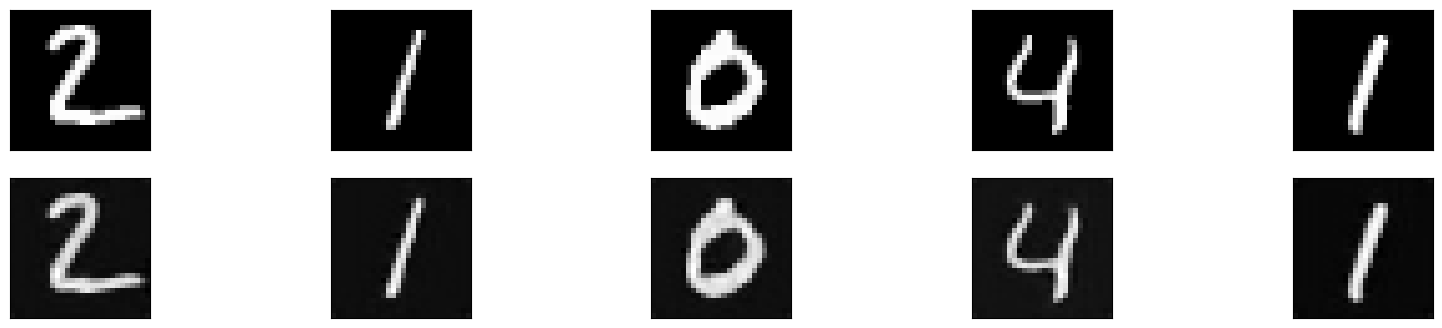

In [44]:
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n + 1, 1):
    # original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # reconstructed
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

다음은 CEM PN, PP를 구하기 위한 표본을 시각화하고 있다.

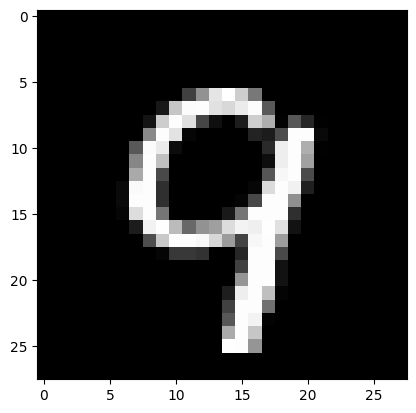

In [51]:
idx = 16
X_sample = X_test[idx].reshape((1,) + X_test[idx].shape)
plt.imshow(X_sample.reshape(28, 28))

위의 표본에 대하여 CEM PN을 구하기 위해 `CEM`에 전달한 인자를 정의한다.

In [49]:
cem_pn_config = {
    'mode': 'PN',
    'shape': (1,) + X_train.shape[1:],
    'kappa': 0.0,
    'beta': 0.1,
    'gamma': 100,
    'c_init': 3.0,
    'c_steps': 10,
    'max_iterations': 1000,
    'feature_range': (X_train.min(), X_train.max()),
    'clip':(-1000.0, 1000.0),
    'learning_rate_init': 1e-2,
    'no_info_val': -1.0,
    'ae_model': ae
}

CEM에 앞서 정의한 CNN과 인자를 전달하여 객체화한다.

`.explain(표본)` 메서드를 통해 해당 표본의 PN을 구하게 된다.

In [ ]:
cem_pn = CEM(cnn, **cem_pn_config)
explanation_pn = cem_pn.explain(X_sample)

숫자 9를 4로 변경하였으며 변경된 이미지는 다음과 같다.

Pertinent negative prediction: 4


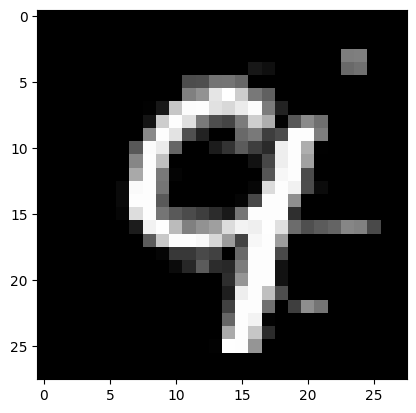

In [ ]:
print(f"Pertinent negative prediction: {explanation_pn.PN_pred}")
plt.imshow(explanation_pn.PN.reshape(28, 28))

다음으로 CEM PP를 구하기 위해 앞서 정의한 인자에서 `mode`만 `'PP'`로 변경하여 동일 표본에 대해 Pertinent Positive를 반환하고 있다.

In [ ]:
cem_pp_config = cem_pn_config.copy()
cem_pp_config['mode'] = 'PP'

cem_pp = CEM(cnn, **cem_pp_config)
explanation_pp = cem_pp.explain(X_sample)

다음은 PP 결과를 시각화 한다. 표시된 픽셀 집합이 숫자 9로 예측하는 것에 기여도가 높다고 판단할 수 있다.

Pertinent positive prediction: 9


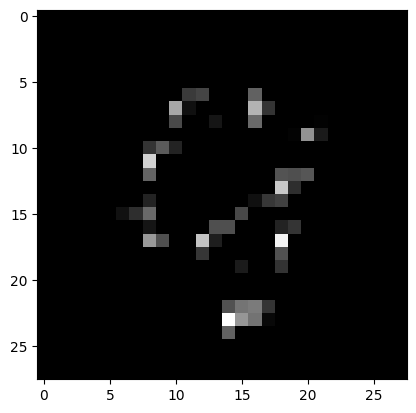

In [ ]:
print(f"Pertinent positive prediction: {explanation_pp.PP_pred}")
plt.imshow(explanation_pp.PP.reshape(28, 28))